<h1>Unsupervised discovery of patient phenotypes and survival outcomes</h1>

In [32]:
# 1. Load Necessary Libraries
suppressPackageStartupMessages({
# --- Data Manipulation & Cleaning ---
library(tidyverse)    # Essential suite for data science (dplyr, ggplot2, etc.)
library(tidyr)        # For pivoting data (transposing tables for A4 format)
library(purrr)        # For functional programming and mapping labels
library(lubridate)    # For handling date objects (Diagnosis and Death dates)
library(fastDummies)  # To transform categorical variables into numeric dummy columns

# --- Clustering & Dimensionality Reduction ---
library(cluster)      # For Gower distance (daisy) and PAM clustering
library(factoextra)   # For cluster validation plots (Silhouette/Elbow) and PCA
library(umap)         # For non-linear dimensionality reduction and visualization
library(fmsb)         # For creating the phenotypic radar/spider charts

# --- Survival Analysis ---
library(survival)     # Core survival analysis functions (Surv, survfit)
library(survminer)    # For publication-ready Kaplan-Meier plots (ggsurvplot)

# --- Statistical Testing & Summaries ---
library(broom)        # For cleaning and formatting statistical test results (p-values)
library(scales)       # For map/chart scaling and conditional color formatting

# --- Table & Heatmap Formatting ---
library(gt)           # For generating professional, journal-standard HTML/Word tables
library(pheatmap)     # For creating scaled phenotypic heatmaps with numeric overlays

# --- Figure Assembly & Layout ---
library(grid)         # For low-level graphical object control
library(gridExtra)    # For arranging multiple plots on a single page
suppressWarnings(library(cowplot))    # For combining the Heatmap (Panel A) and KM Plot (Panel B)
    
    })


<h2>Section 1: Data Preparation & Encoding</h2>

In [2]:
# 2. Load Data
my_data <- read.csv("data/data.csv")

In [3]:
# 3. CLEANING AND TRANSLATION
# We filter out data collection sources (INEC) to focus on Health Sectors
df_clean_en <- my_data %>%
  filter(!Establecimiento %in% c("INEC", "Desconocido", "OTROS"),
         !Nivel_educ == "Se desconoce") %>%
  mutate(
    # --- Numeric Variables ---
    # Age at Diagnosis
    Age_at_Diagnosis = as.numeric(Anio_diag - Anio_nac),
    Status = factor(Estado_vital, 
                             levels = c("Fallecido", "Vivo"),
                             labels = c(1, 0)),
    
    # Years with Cancer (Survival Time)
    End_Date = if_else(!is.na(Fecha_fall), as.Date(Fecha_fall), as.Date(Fecha_ultcont)),
    Years_with_Cancer = as.numeric(difftime(End_Date, as.Date(Fecha_diag), units = "days")) / 365.25,
    
    # --- Categorical Variables (Translated) ---
    Gender = as.factor(Sexo),
    
    Education_Level = factor(Nivel_educ, 
                             levels = c("Ninguna", "Primaria", "Secundaria", "Superior"),
                             labels = c("No Formal", "Primary", "Secondary", "Higher Education")),
    
    Healthcare_Sector = case_when(
      Establecimiento == "Privados no SOLCA" ~ "Private Sector",
      Establecimiento == "MSP" ~ "Public (MSP)",
      Establecimiento == "IESS" ~ "Social Security",
      Establecimiento == "SOLCA" ~ "Specialized Oncology",
      TRUE ~ "Other"
    ),
    Healthcare_Sector = as.factor(Healthcare_Sector),

      Morf_tumor_CIEO3 = toupper(Morf_tumor_CIEO3),

     Cancer_Subtype = case_when(
      # 1. Hodgkin: Must contain "HODGKIN" but NOT "NO HODGKIN"
      str_detect(Morf_tumor_CIEO3, "HODGKIN") & !str_detect(Morf_tumor_CIEO3, "NO HODGKIN") ~ "Hodgkin Lymphoma",

      # 2. DLBCL: Contains "DIFUSO" (Diffuse)
      str_detect(Morf_tumor_CIEO3, "DIFUSO") ~ "Diffuse Large B-Cell (DLBCL)",

      # 3. Follicular
      str_detect(Morf_tumor_CIEO3, "FOLICULAR") ~ "Follicular Lymphoma",

      # 4. Burkitt
      str_detect(Morf_tumor_CIEO3, "BURKITT") ~ "Burkitt Lymphoma",

      # 5. T-Cell / NK-Cell
      str_detect(Morf_tumor_CIEO3, "T") | str_detect(Morf_tumor_CIEO3, "NK") ~ "Mature T/NK-Cell",

      # 6. Others/NOS (Everything else)
      TRUE ~ "B-Cell / NOS / Other"
    ),

    Cancer_Subtype = as.factor(Cancer_Subtype),

      
     # --- PRIMARY TUMOR SITE (Precise Mapping) ---
    Primary_Site = fct_lump(as.factor(Localiz_tumor_r), n = 5),
    Primary_Site_Gastric = case_when(
      grepl("^C77", Localiz_tumor_r) ~ "Nodal",
      grepl("^C16", Localiz_tumor_r) ~ "Gastric (Extranodal)",
      TRUE ~ "Other Extranodal"
    ),
    Primary_Site_Gastric = as.factor(Primary_Site_Gastric),
 
    Number_of_Tumors = as.numeric(Num_tumores)
  ) %>%
  # Remove rows with invalid survival or age data
  filter(Age_at_Diagnosis >= 18, Years_with_Cancer >= 0) %>%
  select(Gender, Age_at_Diagnosis, Years_with_Cancer, Education_Level, 
         Healthcare_Sector, Cancer_Subtype, Primary_Site,Primary_Site_Gastric,Status)

In [4]:
# 4. STANDARDIZATION AND FINAL FILTER
# We scale numeric values so Age and Survival have equal weight with categories
df_for_clustering <- df_clean_en %>%
  mutate(
    Age_at_Diagnosis = as.numeric(scale(Age_at_Diagnosis))
  )%>%
  select(Gender, Age_at_Diagnosis, Education_Level, 
         Healthcare_Sector,  Cancer_Subtype, Primary_Site)

print(paste("Cleaned Patients for Analysis:", nrow(df_clean_en)))
head(df_for_clustering)

[1] "Cleaned Patients for Analysis: 3989"


,Gender,Age_at_Diagnosis,Education_Level,Healthcare_Sector,Cancer_Subtype,Primary_Site
,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
1,Hombre,0.36853981,Higher Education,Specialized Oncology,Diffuse Large B-Cell (DLBCL),Other
2,Mujer,0.91809135,Higher Education,Public (MSP),Follicular Lymphoma,Other
3,Mujer,-1.49993542,Secondary,Private Sector,B-Cell / NOS / Other,Other
4,Mujer,1.30277743,Secondary,Social Security,Diffuse Large B-Cell (DLBCL),Other
5,Hombre,0.09376405,Primary,Public (MSP),Diffuse Large B-Cell (DLBCL),Other
6,Hombre,0.47845012,Primary,Social Security,B-Cell / NOS / Other,Other


<h2>Section 2: Unsupervised Phenotyping (PAM Clustering)</h2>

In [5]:
# 5. Calculate the Gower Distance Matrix
# This represents how 'similar' each patient is to every other patient
gower_dist <- daisy(df_for_clustering, metric = "gower")

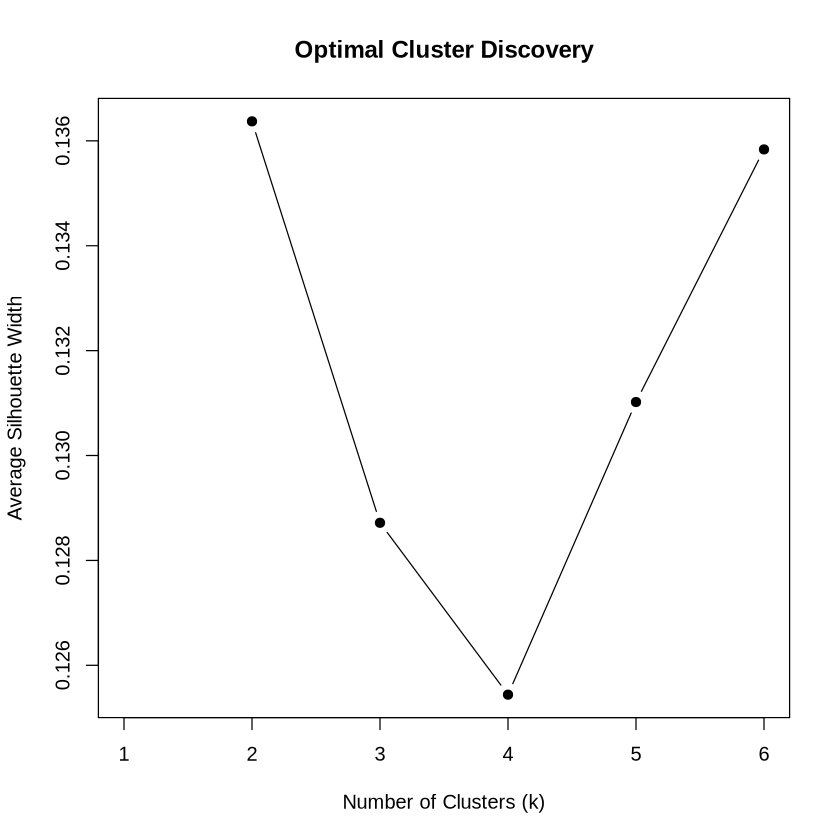

In [6]:
# 6. Find the best 'k' (Number of Clusters)
sil_width <- c(NA)
for(i in 2:6){
  pam_fit <- pam(gower_dist, diss = TRUE, k = i)
  sil_width[i] <- pam_fit$silinfo$avg.width
}

plot(1:6, sil_width, type = "b", pch = 19, 
     xlab = "Number of Clusters (k)", ylab = "Average Silhouette Width",
     main = "Optimal Cluster Discovery")

In [7]:
# 7. Execute PAM Clustering
set.seed(42)
final_pam <- pam(gower_dist, diss = TRUE, k = 4)

  cluster size ave.sil.width
1       1  841          0.09
2       2  769          0.17
3       3 1222          0.14
4       4 1157          0.10


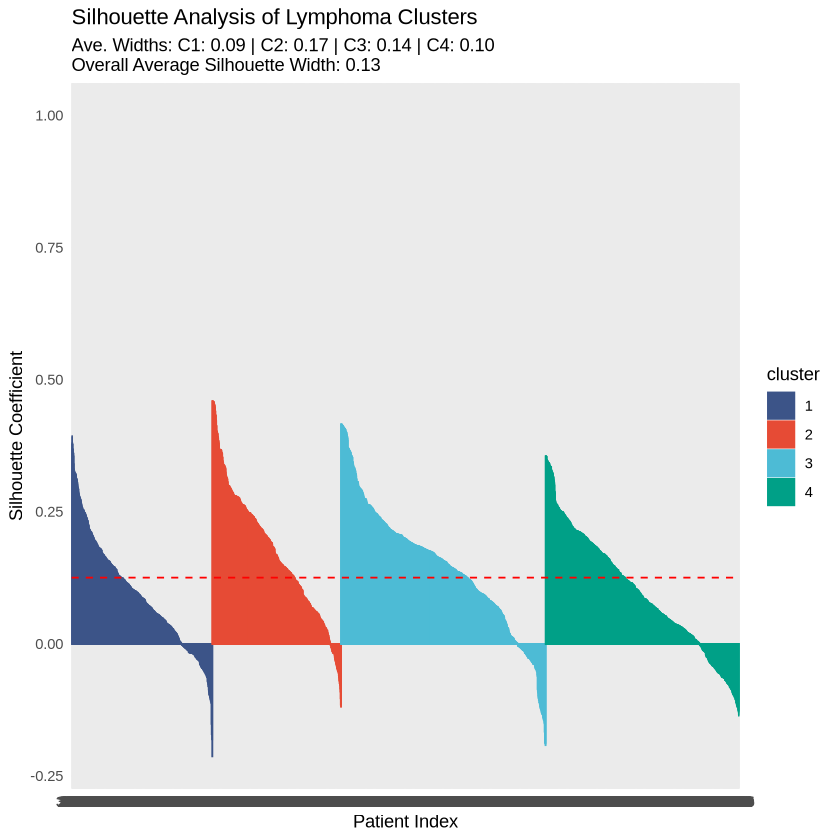

In [8]:
# 8. Calculate the Silhouette Information
# This uses the cluster assignments from your PAM results and the original distance matrix
sil_info <- silhouette(final_pam$clustering, dist = gower_dist)

# Create figure Silhouette
# Define the text for the subtitle
sil_text <- paste0("Ave. Widths: C1: 0.09 | C2: 0.17 | C3: 0.14 | C4: 0.10\n",
                   "Overall Average Silhouette Width: 0.13")

suppressWarnings({
  fviz_silhouette(sil_info, palette = c("#3C5488FF", "#E64B35FF", "#4DBBD5FF", "#00A087FF")) +
    labs(
      title = "Silhouette Analysis of Lymphoma Clusters",
      subtitle = sil_text,
      x = "Patient Index",
      y = "Silhouette Coefficient"
    ) +
    theme_minimal()
})

In [9]:
# 8. Add Cluster IDs to the English dataset
df_clean_en$Cluster <- as.factor(final_pam$clustering)
head(df_clean_en)

,Gender,Age_at_Diagnosis,Years_with_Cancer,Education_Level,Healthcare_Sector,Cancer_Subtype,Primary_Site,Primary_Site_Gastric,Status,Cluster
,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,Hombre,65,7.10472279,Higher Education,Specialized Oncology,Diffuse Large B-Cell (DLBCL),Other,Other Extranodal,0,1
2,Mujer,75,6.43394935,Higher Education,Public (MSP),Follicular Lymphoma,Other,Other Extranodal,1,2
3,Mujer,31,7.55920602,Secondary,Private Sector,B-Cell / NOS / Other,Other,Other Extranodal,1,1
4,Mujer,82,0.64887064,Secondary,Social Security,Diffuse Large B-Cell (DLBCL),Other,Other Extranodal,1,2
5,Hombre,60,0.06844627,Primary,Public (MSP),Diffuse Large B-Cell (DLBCL),Other,Other Extranodal,1,2
6,Hombre,67,2.77618070,Primary,Social Security,B-Cell / NOS / Other,Other,Other Extranodal,1,3


In [10]:
# 9. Generate the Summary Table
manuscript_table <- df_clean_en %>%
  group_by(Cluster) %>%
  summarise(
    n = n(),
    Median_Age = round(median(Age_at_Diagnosis), 1),
    Median_Survival_Yrs = round(median(Years_with_Cancer), 2),
    Dominant_Sector = names(sort(table(Healthcare_Sector), decreasing = TRUE)[1]),
    Dominant_Education = names(sort(table(Education_Level), decreasing = TRUE)[1]),
    Pct_Public_Sector = round(sum(Healthcare_Sector == "Public (MSP)") / n() * 100, 1)
  )

print(manuscript_table, width = Inf)

# A tibble: 4 × 7
  Cluster     n Median_Age Median_Survival_Yrs Dominant_Sector     
  <fct>   <int>      <dbl>               <dbl> <chr>               
1 1         841         49                5.69 Private Sector      
2 2         769         71                1.14 Public (MSP)        
3 3        1222         65                1.36 Social Security     
4 4        1157         55                4.48 Specialized Oncology
  Dominant_Education Pct_Public_Sector
  <chr>                          <dbl>
1 Higher Education                 8.9
2 Primary                         47.2
3 Primary                         11.7
4 Secondary                       10.6


In [11]:
# 10. Generate full spope table
full_scope_table <- df_clean_en %>%
  group_by(Cluster) %>%
  summarise(
    # --- General ---
    Total_n = n(),
    Pct_of_Registry = round(n() / nrow(df_clean_en) * 100, 1),
    Median_Age = round(median(Age_at_Diagnosis), 1),
    Median_Survival_Yrs = round(median(Years_with_Cancer), 2),
    
    # --- Healthcare Sector (%) ---
    Pct_Public_MSP = round(sum(Healthcare_Sector == "Public (MSP)") / n() * 100, 1),
    Pct_Social_Sec_IESS = round(sum(Healthcare_Sector == "Social Security") / n() * 100, 1),
    Pct_Specialized_SOLCA = round(sum(Healthcare_Sector == "Specialized Oncology") / n() * 100, 1),
    Pct_Private = round(sum(Healthcare_Sector == "Private Sector") / n() * 100, 1),
    
    # --- Education Level (%) ---
    Pct_No_Formal_Edu = round(sum(Education_Level == "No Formal") / n() * 100, 1),
    Pct_Primary_Edu = round(sum(Education_Level == "Primary") / n() * 100, 1),
    Pct_Secondary_Edu = round(sum(Education_Level == "Secondary") / n() * 100, 1),
    Pct_Higher_Edu = round(sum(Education_Level == "Higher Education") / n() * 100, 1),
    
    # --- Clinical Characteristics (Fixed String Matching) ---
    # We look for the codes anywhere in the text labels
    Pct_DLBCL_Subtype = round(sum(grepl("DLBCL", Cancer_Subtype)) / n() * 100, 1), 
    Pct_Gastric_Site = round(sum(grepl("C169", Primary_Site)) / n() * 100, 1),
    
    # --- Gender ---
    Pct_Male = round(sum(Gender == "Hombre") / n() * 100, 1)
  )

# Print the result
print(as.data.frame(full_scope_table))

  Cluster Total_n Pct_of_Registry Median_Age Median_Survival_Yrs Pct_Public_MSP
1       1     841            21.1         49                5.69            8.9
2       2     769            19.3         71                1.14           47.2
3       3    1222            30.6         65                1.36           11.7
4       4    1157            29.0         55                4.48           10.6
  Pct_Social_Sec_IESS Pct_Specialized_SOLCA Pct_Private Pct_No_Formal_Edu
1                20.6                  16.6        53.9               2.6
2                19.0                  15.2        18.6               9.5
3                66.2                  11.9        10.1               5.3
4                22.2                  48.7        18.5               6.4
  Pct_Primary_Edu Pct_Secondary_Edu Pct_Higher_Edu Pct_DLBCL_Subtype
1             8.9              24.4           64.1              18.7
2            72.4              13.3            4.8              61.1
3            56.8      

In [12]:
# 11. Generate Phenotypic Characterization of Lymphoma Patients table
# 1. Prepare labels and domain structure
table_to_plot <- full_scope_table %>%
  mutate(Cluster_Name = case_when(
    Cluster == 1 ~ "Young / Private (Advantaged)",
    Cluster == 2 ~ "Elderly / Public (Vulnerable)",
    Cluster == 3 ~ "Middle-Age / Social Security",
    Cluster == 4 ~ "Specialized / SOLCA (High Access)"
  )) %>%
  select(Cluster_Name, everything(), -Cluster)

# 2. Create the GT Table with the new syntax
formatted_table <- table_to_plot %>%
  gt() %>%
  tab_header(
    title = md("**Phenotypic Characterization of Lymphoma Patients**"),
    subtitle = "Unsupervised Cluster Analysis from the Quito Cancer Registry (n=4,318)"
  ) %>%
  # Grouping the Columns for Clarity
  tab_spanner(label = "Demographics", columns = c(Median_Age, Pct_Male)) %>%
  tab_spanner(label = "Socioeconomics", columns = c(Pct_Public_MSP, Pct_Social_Sec_IESS, Pct_Specialized_SOLCA, Pct_Private, Pct_No_Formal_Edu, Pct_Primary_Edu, Pct_Secondary_Edu, Pct_Higher_Edu)) %>%
  tab_spanner(label = "Clinical & Outcome", columns = c(Median_Survival_Yrs, Pct_DLBCL_Subtype, Pct_Gastric_Site)) %>%
  
  # Professional Renaming
  cols_label(
    Cluster_Name = "Patient Phenotype",
    Total_n = "N",
    Pct_of_Registry = "% of Total",
    Median_Age = "Median Age",
    Median_Survival_Yrs = "Med. Survival (Yrs)",
    Pct_Public_MSP = "Public (MSP) %",
    Pct_Social_Sec_IESS = "IESS %",
    Pct_Specialized_SOLCA = "SOLCA %",
    Pct_Private = "Private %",
    Pct_No_Formal_Edu = "No Formal Ed %",
    Pct_Primary_Edu = "Primary %",
    Pct_Secondary_Edu = "Secondary %",
    Pct_Higher_Edu = "Higher Ed %",
    Pct_DLBCL_Subtype = "DLBCL %",
    Pct_Gastric_Site = "Gastric %",
    Pct_Male = "Male %"
  ) %>%


  
  # NEW SYNTAX: Conditional Formatting using 'fn'
  data_color(
    columns = Median_Survival_Yrs,
    fn = scales::col_numeric(
      palette = c("#fee5d9", "#fcae91", "#fb6a4a", "#de2d26", "#a50f15"), # Red gradient
      domain = NULL,
      reverse = TRUE # Low survival = Dark Red
    )
  ) %>%
  
  # Highlight the Public Sector Concentration
  data_color(
    columns = Pct_Public_MSP,
    fn = scales::col_numeric(
      palette = c("#eff3ff", "#bdd7e7", "#6baed6", "#3182bd", "#08519c"), # Blue gradient
      domain = NULL
    )
  ) %>%
  
  # Finishing Touches
  fmt_number(columns = everything(), decimals = 1) %>%
  tab_options(
    table.font.size = px(12),
    column_labels.font.weight = "bold"
  )

# Show the table
#formatted_table


<div id="iydemetbhc" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#iydemetbhc table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#iydemetbhc thead, #iydemetbhc tbody, #iydemetbhc tfoot, #iydemetbhc tr, #iydemetbhc td, #iydemetbhc th {
  border-style: none;
}

#iydemetbhc p {
  margin: 0;
  padding: 0;
}

#iydemetbhc .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 12px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: auto;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #A8A8A8;
  border-left-style: none;
  border-left-width: 2px;
  border-left-color: #D3D3D3;
}

#iydemetbhc .gt_caption {
  padding-top: 4px;
  padding-bottom: 4px;
}

#iydemetbhc .gt_title {
  color: #333333;
  font-size: 125%;
  font-weight: initial;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 5px;
  padding-right: 5px;
  border-bottom-color: #FFFFFF;
  border-bottom-width: 0;
}

#iydemetbhc .gt_subtitle {
  color: #333333;
  font-size: 85%;
  font-weight: initial;
  padding-top: 3px;
  padding-bottom: 5px;
  padding-left: 5px;
  padding-right: 5px;
  border-top-color: #FFFFFF;
  border-top-width: 0;
}

#iydemetbhc .gt_heading {
  background-color: #FFFFFF;
  text-align: center;
  border-bottom-color: #FFFFFF;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
}

#iydemetbhc .gt_bottom_border {
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
}

#iydemetbhc .gt_col_headings {
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
}

#iydemetbhc .gt_col_heading {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: bold;
  text-transform: inherit;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
  vertical-align: bottom;
  padding-top: 5px;
  padding-bottom: 6px;
  padding-left: 5px;
  padding-right: 5px;
  overflow-x: hidden;
}

#iydemetbhc .gt_column_spanner_outer {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: bold;
  text-transform: inherit;
  padding-top: 0;
  padding-bottom: 0;
  padding-left: 4px;
  padding-right: 4px;
}

#iydemetbhc .gt_column_spanner_outer:first-child {
  padding-left: 0;
}

#iydemetbhc .gt_column_spanner_outer:last-child {
  padding-right: 0;
}

#iydemetbhc .gt_column_spanner {
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  vertical-align: bottom;
  padding-top: 5px;
  padding-bottom: 5px;
  overflow-x: hidden;
  display: inline-block;
  width: 100%;
}

#iydemetbhc .gt_spanner_row {
  border-bottom-style: hidden;
}

#iydemetbhc .gt_group_heading {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: initial;
  text-transform: inherit;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
  vertical-align: middle;
  text-align: left;
}

#iydemetbhc .gt_empty_group_heading {
  padding: 0.5px;
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: initial;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  vertical-align: middle;
}

#iydemetbhc .gt_from_md > :first-child {
  margin-top: 0;
}

#iydemetbhc .gt_from_md > :last-child {
  margin-bottom: 0;
}

#iydemetbhc .gt_row {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  margin: 10px;
  border-top-style: solid;
  border-top-width: 1px;
  border-top-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
  vertical-align: middle;
  overflow-x: hidden;
}

#iydemetbhc .gt_stub {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: initial;
  text-transform: inherit;
  border-right-style: solid;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
  padding-left: 5px;
  padding-right: 5px;
}

#iydemetbhc .gt_stub_row_group {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: initial;
  text-transform: inherit;
  border-right-style: solid;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
  padding-left: 5px;
  padding-right: 5px;
  vertical-align: top;
}

#iydemetbhc .gt_row_group_first td {
  border-top-width: 2px;
}

#iydemetbhc .gt_row_group_first th {
  border-top-width: 2px;
}

#iydemetbhc .gt_summary_row {
  color: #333333;
  background-color: #FFFFFF;
  text-transform: inherit;
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
}

#iydemetbhc .gt_first_summary_row {
  border-top-style: solid;
  border-top-color: #D3D3D3;
}

#iydemetbhc .gt_first_summary_row.thick {
  border-top-width: 2px;
}

#iydemetbhc .gt_last_summary_row {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
}

#iydemetbhc .gt_grand_summary_row {
  color: #333333;
  background-color: #FFFFFF;
  text-transform: inherit;
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
}

#iydemetbhc .gt_first_grand_summary_row {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  border-top-style: double;
  border-top-width: 6px;
  border-top-color: #D3D3D3;
}

#iydemetbhc .gt_last_grand_summary_row_top {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  border-bottom-style: double;
  border-bottom-width: 6px;
  border-bottom-color: #D3D3D3;
}

#iydemetbhc .gt_striped {
  background-color: rgba(128, 128, 128, 0.05);
}

#iydemetbhc .gt_table_body {
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
}

#iydemetbhc .gt_footnotes {
  color: #333333;
  background-color: #FFFFFF;
  border-bottom-style: none;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 2px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
}

#iydemetbhc .gt_footnote {
  margin: 0px;
  font-size: 90%;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 5px;
  padding-right: 5px;
}

#iydemetbhc .gt_sourcenotes {
  color: #333333;
  background-color: #FFFFFF;
  border-bottom-style: none;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 2px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
}

#iydemetbhc .gt_sourcenote {
  font-size: 90%;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 5px;
  padding-right: 5px;
}

#iydemetbhc .gt_left {
  text-align: left;
}

#iydemetbhc .gt_center {
  text-align: center;
}

#iydemetbhc .gt_right {
  text-align: right;
  font-variant-numeric: tabular-nums;
}

#iydemetbhc .gt_font_normal {
  font-weight: normal;
}

#iydemetbhc .gt_font_bold {
  font-weight: bold;
}

#iydemetbhc .gt_font_italic {
  font-style: italic;
}

#iydemetbhc .gt_super {
  font-size: 65%;
}

#iydemetbhc .gt_footnote_marks {
  font-size: 75%;
  vertical-align: 0.4em;
  position: initial;
}

#iydemetbhc .gt_asterisk {
  font-size: 100%;
  vertical-align: 0;
}

#iydemetbhc .gt_indent_1 {
  text-indent: 5px;
}

#iydemetbhc .gt_indent_2 {
  text-indent: 10px;
}

#iydemetbhc .gt_indent_3 {
  text-indent: 15px;
}

#iydemetbhc .gt_indent_4 {
  text-indent: 20px;
}

#iydemetbhc .gt_indent_5 {
  text-indent: 25px;
}

#iydemetbhc .katex-display {
  display: inline-flex !important;
  margin-bottom: 0.75em !important;
}

#iydemetbhc div.Reactable > div.rt-table > div.rt-thead > div.rt-tr.rt-tr-group-header > div.rt-th-group:after {
  height: 0px !important;
}
</style>
  <table class="gt_table" data-quarto-disable-processing="false" data-quarto-bootstrap="false">
  <thead>
    <tr class="gt_heading">
      <td colspan="16" class="gt_heading gt_title gt_font_normal" style><span class='gt_from_md'><strong>Phenotypic Characterization of Lymphoma Patients</strong></span></td>
    </tr>
    <tr class="gt_heading">
      <td colspan="16" class="gt_heading gt_subtitle gt_font_normal gt_bottom_border" style>Unsupervised Cluster Analysis from the Quito Cancer Registry (n=4,318)</td>
    </tr>
    <tr class="gt_col_headings gt_spanner_row">
      <th class="gt_col_heading gt_columns_bottom_border gt_left" rowspan="2" colspan="1" scope="col" id="Cluster_Name">Patient Phenotype</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="2" colspan="1" scope="col" id="Total_n">N</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="2" colspan="1" scope="col" id="Pct_of_Registry">% of Total</th>
      <th class="gt_center gt_columns_top_border gt_column_spanner_outer" rowspan="1" colspan="2" scope="colgroup" id="Demographics">
        <div class="gt_column_spanner">Demographics</div>
      </th>
      <th class="gt_center gt_columns_top_border gt_column_spanner_outer" rowspan="1" colspan="3" scope="colgroup" id="Clinical &amp; Outcome">
        <div class="gt_column_spanner">Clinical &amp; Outcome</div>
      </th>
      <th class="gt_center gt_columns_top_border gt_column_spanner_outer" rowspan="1" colspan="8" scope="colgroup" id="Socioeconomics">
        <div class="gt_column_spanner">Socioeconomics</div>
      </th>
    </tr>
    <tr class="gt_col_headings">
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Median_Age">Median Age</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Pct_Male">Male %</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Median_Survival_Yrs">Med. Survival (Yrs)</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Pct_DLBCL_Subtype">DLBCL %</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Pct_Gastric_Site">Gastric %</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Pct_Public_MSP">Public (MSP) %</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Pct_Social_Sec_IESS">IESS %</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Pct_Specialized_SOLCA">SOLCA %</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Pct_Private">Private %</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Pct_No_Formal_Edu">No Formal Ed %</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Pct_Primary_Edu">Primary %</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Pct_Secondary_Edu">Secondary %</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="Pct_Higher_Edu">Higher Ed %</th>
    </tr>
  </thead>
  <tbody class="gt_table_body">
    <tr><td headers="Cluster_Name" class="gt_row gt_left">Young / Private (Advantaged)</td>
<td headers="Total_n" class="gt_row gt_right">841.0</td>
<td headers="Pct_of_Registry" class="gt_row gt_right">21.1</td>
<td headers="Median_Age" class="gt_row gt_right">49.0</td>
<td headers="Pct_Male" class="gt_row gt_right">78.5</td>
<td headers="Median_Survival_Yrs" class="gt_row gt_right" style="background-color: #FEE5D9; color: #000000;">5.7</td>
<td headers="Pct_DLBCL_Subtype" class="gt_row gt_right">18.7</td>
<td headers="Pct_Gastric_Site" class="gt_row gt_right">7.7</td>
<td headers="Pct_Public_MSP" class="gt_row gt_right" style="background-color: #EFF3FF; color: #000000;">8.9</td>
<td headers="Pct_Social_Sec_IESS" class="gt_row gt_right">20.6</td>
<td headers="Pct_Specialized_SOLCA" class="gt_row gt_right">16.6</td>
<td headers="Pct_Private" class="gt_row gt_right">53.9</td>
<td headers="Pct_No_Formal_Edu" class="gt_row gt_right">2.6</td>
<td headers="Pct_Primary_Edu" class="gt_row gt_right">8.9</td>
<td headers="Pct_Secondary_Edu" class="gt_row gt_right">24.4</td>
<td headers="Pct_Higher_Edu" class="gt_row gt_right">64.1</td></tr>
    <tr><td headers="Cluster_Name" class="gt_row gt_left">Elderly / Public (Vulnerable)</td>
<td headers="Total_n" class="gt_row gt_right">769.0</td>
<td headers="Pct_of_Registry" class="gt_row gt_right">19.3</td>
<td headers="Median_Age" class="gt_row gt_right">71.0</td>
<td headers="Pct_Male" class="gt_row gt_right">13.9</td>
<td headers="Median_Survival_Yrs" class="gt_row gt_right" style="background-color: #A50F15; color: #FFFFFF;">1.1</td>
<td headers="Pct_DLBCL_Subtype" class="gt_row gt_right">61.1</td>
<td headers="Pct_Gastric_Site" class="gt_row gt_right">8.6</td>
<td headers="Pct_Public_MSP" class="gt_row gt_right" style="background-color: #08519C; color: #FFFFFF;">47.2</td>
<td headers="Pct_Social_Sec_IESS" class="gt_row gt_right">19.0</td>
<td headers="Pct_Specialized_SOLCA" class="gt_row gt_right">15.2</td>
<td headers="Pct_Private" class="gt_row gt_right">18.6</td>
<td headers="Pct_No_Formal_Edu" class="gt_row gt_right">9.5</td>
<td headers="Pct_Primary_Edu" class="gt_row gt_right">72.4</td>
<td headers="Pct_Secondary_Edu" class="gt_row gt_right">13.3</td>
<td headers="Pct_Higher_Edu" class="gt_row gt_right">4.8</td></tr>
    <tr><td headers="Cluster_Name" class="gt_row gt_left">Middle-Age / Social Security</td>
<td headers="Total_n" class="gt_row gt_right">1,222.0</td>
<td headers="Pct_of_Registry" class="gt_row gt_right">30.6</td>
<td headers="Median_Age" class="gt_row gt_right">65.0</td>
<td headers="Pct_Male" class="gt_row gt_right">85.8</td>
<td headers="Median_Survival_Yrs" class="gt_row gt_right" style="background-color: #B01518; color: #FFFFFF;">1.4</td>
<td headers="Pct_DLBCL_Subtype" class="gt_row gt_right">56.9</td>
<td headers="Pct_Gastric_Site" class="gt_row gt_right">8.9</td>
<td headers="Pct_Public_MSP" class="gt_row gt_right" style="background-color: #E0EBF8; color: #000000;">11.7</td>
<td headers="Pct_Social_Sec_IESS" class="gt_row gt_right">66.2</td>
<td headers="Pct_Specialized_SOLCA" class="gt_row gt_right">11.9</td>
<td headers="Pct_Private" class="gt_row gt_right">10.1</td>
<td headers="Pct_No_Formal_Edu" class="gt_row gt_right">5.3</td>
<td headers="Pct_Primary_Edu" class="gt_row gt_right">56.8</td>
<td headers="Pct_Secondary_Edu" class="gt_row gt_right">21.9</td>
<td headers="Pct_Higher_Edu" class="gt_row gt_right">16.0</td></tr>
    <tr><td headers="Cluster_Name" class="gt_row gt_left">Specialized / SOLCA (High Access)</td>
<td headers="Total_n" class="gt_row gt_right">1,157.0</td>
<td headers="Pct_of_Registry" class="gt_row gt_right">29.0</td>
<td headers="Median_Age" class="gt_row gt_right">55.0</td>
<td headers="Pct_Male" class="gt_row gt_right">17.5</td>
<td headers="Median_Survival_Yrs" class="gt_row gt_right" style="background-color: #FCAA8C; color: #000000;">4.5</td>
<td headers="Pct_DLBCL_Subtype" class="gt_row gt_right">50.8</td>
<td headers="Pct_Gastric_Site" class="gt_row gt_right">7.7</td>
<td headers="Pct_Public_MSP" class="gt_row gt_right" style="background-color: #E6EEFB; color: #000000;">10.6</td>
<td headers="Pct_Social_Sec_IESS" class="gt_row gt_right">22.2</td>
<td headers="Pct_Specialized_SOLCA" class="gt_row gt_right">48.7</td>
<td headers="Pct_Private" class="gt_row gt_right">18.5</td>
<td headers="Pct_No_Formal_Edu" class="gt_row gt_right">6.4</td>
<td headers="Pct_Primary_Edu" class="gt_row gt_right">13.5</td>
<td headers="Pct_Secondary_Edu" class="gt_row gt_right">65.9</td>
<td headers="Pct_Higher_Edu" class="gt_row gt_right">14.2</td></tr>
  </tbody>
  
</table>
</div>

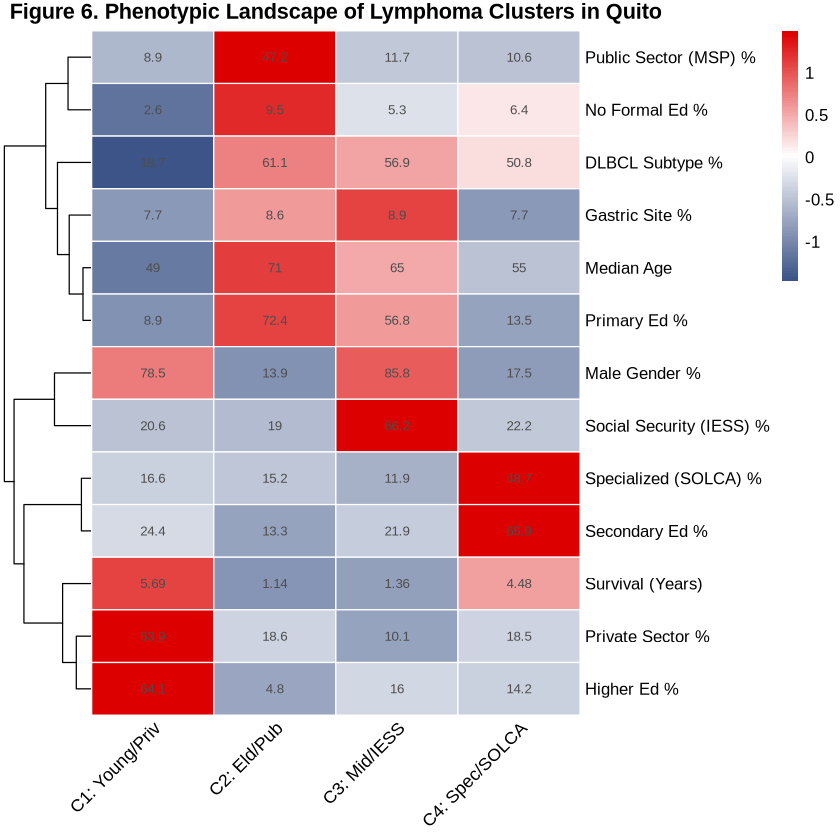

In [13]:
# 13. Create the Heatmap
# Prepare the data: Comprehensive Selection
heatmap_prep <- full_scope_table %>%
  select(
    Cluster, 
    `Median Age` = Median_Age,
    `Male Gender %` = Pct_Male,
    `Survival (Years)` = Median_Survival_Yrs,
    `Public Sector (MSP) %` = Pct_Public_MSP,
    `Social Security (IESS) %` = Pct_Social_Sec_IESS,
    `Specialized (SOLCA) %` = Pct_Specialized_SOLCA,
    `Private Sector %` = Pct_Private,
    `No Formal Ed %` = Pct_No_Formal_Edu,
    `Primary Ed %` = Pct_Primary_Edu,
    `Secondary Ed %` = Pct_Secondary_Edu,
    `Higher Ed %` = Pct_Higher_Edu,
    `DLBCL Subtype %` = Pct_DLBCL_Subtype,
    `Gastric Site %` = Pct_Gastric_Site
  ) %>%
  # Rename clusters for better X-axis labels
  mutate(Cluster = case_when(
    Cluster == 1 ~ "C1: Young/Priv",
    Cluster == 2 ~ "C2: Eld/Pub",
    Cluster == 3 ~ "C3: Mid/IESS",
    Cluster == 4 ~ "C4: Spec/SOLCA"
  )) %>%
  column_to_rownames("Cluster")

# Create Matrices
heatmap_scaled <- t(scale(heatmap_prep))
heatmap_labels <- t(as.matrix(heatmap_prep))

# Generate the Final Publication Figure
library(pheatmap)
pheatmap(heatmap_scaled, 
         cluster_rows = TRUE, 
         cluster_cols = FALSE,          # Keep clusters in order to match Table 2
         display_numbers = heatmap_labels, 
         number_format = "%.1f",
         # NEJM/Lancet inspired color palette: Blue (Low) -> White -> Red (High)
         color = colorRampPalette(c("#3C5488FF", "white", "#DC0000FF"))(100), 
         border_color = "white",
         main = "Figure 6. Phenotypic Landscape of Lymphoma Clusters in Quito",
         fontsize_row = 10, 
         fontsize_col = 11,
         angle_col = 45) # 45 degrees looks better with the longer cluster names

In [14]:
# 14. Add p-values for the table
# --- A. Continuous Variables (Kruskal-Wallis) ---
p_age <- kruskal.test(Age_at_Diagnosis ~ Cluster, data = df_clean_en)$p.value
p_surv <- kruskal.test(Years_with_Cancer ~ Cluster, data = df_clean_en)$p.value

# --- B. Categorical Variables (Chi-squared) ---
# B = 2000 is the standard number of simulations for a stable p-value
get_p_cat <- function(var) {
  chisq.test(table(df_clean_en[[var]], df_clean_en$Cluster), 
             simulate.p.value = TRUE, 
             B = 2000)$p.value
}

p_gender <- get_p_cat("Gender")
p_sector <- get_p_cat("Healthcare_Sector")
p_edu    <- get_p_cat("Education_Level")
p_sub    <- get_p_cat("Cancer_Subtype")
p_site   <- get_p_cat("Primary_Site")

# --- C. Create a P-value Vector (formatted for the table) ---
# Medical journals prefer "<0.001" if the value is very small
format_p <- function(p) {
  if (p < 0.001) return("<0.001")
  else return(as.character(round(p, 3)))
}

In [15]:
# 15. Create the manuscript table

table_a4 <- full_scope_table %>%
  # Create ID labels (#1, #2, etc.)
  mutate(Cluster_ID = paste0("#", Cluster)) %>%
  # Assign the high-impact clinical names for the clusters
  mutate(Phenotype = case_when(
    Cluster == 1 ~ "Young / Private",
    Cluster == 2 ~ "Elderly / Public",
    Cluster == 3 ~ "Mid-Age / IESS",
    Cluster == 4 ~ "Spec. / SOLCA"
  )) %>%
  # Organize columns to ensure Cluster ID and Phenotype are the first two
  # This is critical for the pivot_longer logic in your next step
  select(Cluster_ID, Phenotype, Total_n, Pct_of_Registry, 
         Median_Age, Pct_Male, Median_Survival_Yrs, 
         Pct_DLBCL_Subtype, Pct_Gastric_Site,
         Pct_Public_MSP, Pct_Social_Sec_IESS, Pct_Specialized_SOLCA, Pct_Private,
         Pct_No_Formal_Edu, Pct_Primary_Edu, Pct_Secondary_Edu, Pct_Higher_Edu)
# We convert the wide summary into a long format where each row is a variable
table_vertical <- table_a4 %>%
  # Remove ID and Phenotype from the pivot but keep them as headers
  pivot_longer(
    cols = -c(Cluster_ID, Phenotype), 
    names_to = "Variable", 
    values_to = "Value"
  ) %>%
  # Pivot back so Clusters are columns
  pivot_wider(
    names_from = c(Cluster_ID, Phenotype), 
    values_from = Value
  )

# Map the technical names to Publication-Ready Labels
# This step eliminates all abbreviations
variable_labels <- c(
  "Total_n" = "Total Patients (n)",
  "Pct_of_Registry" = "Registry Distribution (%)",
  "Median_Age" = "Median Age (Years)",
  "Pct_Male" = "Male Gender (%)",
  "Median_Survival_Yrs" = "Median Overall Survival (Years)",
  "Pct_DLBCL_Subtype" = "Diffuse Large B-cell Lymphoma (%)",
  "Pct_Gastric_Site" = "Gastric Primary Site (%)",
  "Pct_Public_MSP" = "Public (MSP)",
  "Pct_Social_Sec_IESS" = "Social Security (IESS)",
  "Pct_Specialized_SOLCA" = "Specialized Oncology (SOLCA)",
  "Pct_Private" = "Private Sector",
  "Pct_No_Formal_Edu" = "No Formal Education",
  "Pct_Primary_Edu" = "Primary Education",
  "Pct_Secondary_Edu" = "Secondary Education",
  "Pct_Higher_Edu" = "Higher Education"
)

table_vertical <- table_vertical %>%
  mutate(Variable = variable_labels[Variable])

# Add P-values Column (using the variables calculated previously)
# Mapping specific p-values to their corresponding rows
table_vertical <- table_vertical %>%
  mutate(p_value = case_when(
    Variable == "Median Age (Years)" ~ format_p(p_age),
    Variable == "Male Gender (%)" ~ format_p(p_gender),
    Variable == "Median Overall Survival (Years)" ~ format_p(p_surv),
    Variable == "Diffuse Large B-cell Lymphoma (%)" ~ format_p(p_sub),
    Variable == "Gastric Primary Site (%)" ~ format_p(p_site),
    Variable %in% c("Public (MSP)", "Social Security (IESS)", 
                    "Specialized Oncology (SOLCA)", "Private Sector") ~ format_p(p_sector),
    Variable %in% c("No Formal Education", "Primary Education", 
                    "Secondary Education", "Higher Education") ~ format_p(p_edu),
    TRUE ~ "—"
  ))

# Create the GT Table
gt_final <- table_vertical %>%
  gt() %>%
  tab_header(
    title = md("**Table 2. Clinical and Socioeconomic Characteristics by Patient Cluster**"),
    subtitle = "Population-based analysis from the Quito Cancer Registry (n=3,989)"
  ) %>%
  # Group rows into logical sections
  tab_row_group(label = "Education Level", rows = 12:15) %>%
  tab_row_group(label = "Healthcare Sector", rows = 8:11) %>%
  tab_row_group(label = "Clinical Outcomes", rows = 5:7) %>%
  tab_row_group(label = "Demographics", rows = 1:4) %>%
  
  # Format columns
  cols_label(Variable = "Characteristic", p_value = "p-value") %>%
  fmt_number(columns = -c(Variable, p_value), rows = c(3, 5), decimals = 2) %>%
  fmt_number(columns = -c(Variable, p_value), rows = c(2, 4, 6:15), decimals = 1) %>%
  
  # Styling for Q1 Standards
  tab_options(
    table.font.size = px(11),
    row_group.font.weight = "bold",
    column_labels.font.weight = "bold",
    table.width = pct(100)
  )

# Print final table
#gt_final
# Or save directly to Word
gtsave(gt_final, "tables/Table2_Manuscript.docx")

<div id="wdoslhouag" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
  <style>#wdoslhouag table {
  font-family: system-ui, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif, 'Apple Color Emoji', 'Segoe UI Emoji', 'Segoe UI Symbol', 'Noto Color Emoji';
  -webkit-font-smoothing: antialiased;
  -moz-osx-font-smoothing: grayscale;
}

#wdoslhouag thead, #wdoslhouag tbody, #wdoslhouag tfoot, #wdoslhouag tr, #wdoslhouag td, #wdoslhouag th {
  border-style: none;
}

#wdoslhouag p {
  margin: 0;
  padding: 0;
}

#wdoslhouag .gt_table {
  display: table;
  border-collapse: collapse;
  line-height: normal;
  margin-left: auto;
  margin-right: auto;
  color: #333333;
  font-size: 11px;
  font-weight: normal;
  font-style: normal;
  background-color: #FFFFFF;
  width: 100%;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #A8A8A8;
  border-right-style: none;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #A8A8A8;
  border-left-style: none;
  border-left-width: 2px;
  border-left-color: #D3D3D3;
}

#wdoslhouag .gt_caption {
  padding-top: 4px;
  padding-bottom: 4px;
}

#wdoslhouag .gt_title {
  color: #333333;
  font-size: 125%;
  font-weight: initial;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 5px;
  padding-right: 5px;
  border-bottom-color: #FFFFFF;
  border-bottom-width: 0;
}

#wdoslhouag .gt_subtitle {
  color: #333333;
  font-size: 85%;
  font-weight: initial;
  padding-top: 3px;
  padding-bottom: 5px;
  padding-left: 5px;
  padding-right: 5px;
  border-top-color: #FFFFFF;
  border-top-width: 0;
}

#wdoslhouag .gt_heading {
  background-color: #FFFFFF;
  text-align: center;
  border-bottom-color: #FFFFFF;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
}

#wdoslhouag .gt_bottom_border {
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
}

#wdoslhouag .gt_col_headings {
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
}

#wdoslhouag .gt_col_heading {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: bold;
  text-transform: inherit;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
  vertical-align: bottom;
  padding-top: 5px;
  padding-bottom: 6px;
  padding-left: 5px;
  padding-right: 5px;
  overflow-x: hidden;
}

#wdoslhouag .gt_column_spanner_outer {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: bold;
  text-transform: inherit;
  padding-top: 0;
  padding-bottom: 0;
  padding-left: 4px;
  padding-right: 4px;
}

#wdoslhouag .gt_column_spanner_outer:first-child {
  padding-left: 0;
}

#wdoslhouag .gt_column_spanner_outer:last-child {
  padding-right: 0;
}

#wdoslhouag .gt_column_spanner {
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  vertical-align: bottom;
  padding-top: 5px;
  padding-bottom: 5px;
  overflow-x: hidden;
  display: inline-block;
  width: 100%;
}

#wdoslhouag .gt_spanner_row {
  border-bottom-style: hidden;
}

#wdoslhouag .gt_group_heading {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: bold;
  text-transform: inherit;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
  vertical-align: middle;
  text-align: left;
}

#wdoslhouag .gt_empty_group_heading {
  padding: 0.5px;
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: bold;
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  vertical-align: middle;
}

#wdoslhouag .gt_from_md > :first-child {
  margin-top: 0;
}

#wdoslhouag .gt_from_md > :last-child {
  margin-bottom: 0;
}

#wdoslhouag .gt_row {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  margin: 10px;
  border-top-style: solid;
  border-top-width: 1px;
  border-top-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 1px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 1px;
  border-right-color: #D3D3D3;
  vertical-align: middle;
  overflow-x: hidden;
}

#wdoslhouag .gt_stub {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: initial;
  text-transform: inherit;
  border-right-style: solid;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
  padding-left: 5px;
  padding-right: 5px;
}

#wdoslhouag .gt_stub_row_group {
  color: #333333;
  background-color: #FFFFFF;
  font-size: 100%;
  font-weight: initial;
  text-transform: inherit;
  border-right-style: solid;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
  padding-left: 5px;
  padding-right: 5px;
  vertical-align: top;
}

#wdoslhouag .gt_row_group_first td {
  border-top-width: 2px;
}

#wdoslhouag .gt_row_group_first th {
  border-top-width: 2px;
}

#wdoslhouag .gt_summary_row {
  color: #333333;
  background-color: #FFFFFF;
  text-transform: inherit;
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
}

#wdoslhouag .gt_first_summary_row {
  border-top-style: solid;
  border-top-color: #D3D3D3;
}

#wdoslhouag .gt_first_summary_row.thick {
  border-top-width: 2px;
}

#wdoslhouag .gt_last_summary_row {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
}

#wdoslhouag .gt_grand_summary_row {
  color: #333333;
  background-color: #FFFFFF;
  text-transform: inherit;
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
}

#wdoslhouag .gt_first_grand_summary_row {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  border-top-style: double;
  border-top-width: 6px;
  border-top-color: #D3D3D3;
}

#wdoslhouag .gt_last_grand_summary_row_top {
  padding-top: 8px;
  padding-bottom: 8px;
  padding-left: 5px;
  padding-right: 5px;
  border-bottom-style: double;
  border-bottom-width: 6px;
  border-bottom-color: #D3D3D3;
}

#wdoslhouag .gt_striped {
  background-color: rgba(128, 128, 128, 0.05);
}

#wdoslhouag .gt_table_body {
  border-top-style: solid;
  border-top-width: 2px;
  border-top-color: #D3D3D3;
  border-bottom-style: solid;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
}

#wdoslhouag .gt_footnotes {
  color: #333333;
  background-color: #FFFFFF;
  border-bottom-style: none;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 2px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
}

#wdoslhouag .gt_footnote {
  margin: 0px;
  font-size: 90%;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 5px;
  padding-right: 5px;
}

#wdoslhouag .gt_sourcenotes {
  color: #333333;
  background-color: #FFFFFF;
  border-bottom-style: none;
  border-bottom-width: 2px;
  border-bottom-color: #D3D3D3;
  border-left-style: none;
  border-left-width: 2px;
  border-left-color: #D3D3D3;
  border-right-style: none;
  border-right-width: 2px;
  border-right-color: #D3D3D3;
}

#wdoslhouag .gt_sourcenote {
  font-size: 90%;
  padding-top: 4px;
  padding-bottom: 4px;
  padding-left: 5px;
  padding-right: 5px;
}

#wdoslhouag .gt_left {
  text-align: left;
}

#wdoslhouag .gt_center {
  text-align: center;
}

#wdoslhouag .gt_right {
  text-align: right;
  font-variant-numeric: tabular-nums;
}

#wdoslhouag .gt_font_normal {
  font-weight: normal;
}

#wdoslhouag .gt_font_bold {
  font-weight: bold;
}

#wdoslhouag .gt_font_italic {
  font-style: italic;
}

#wdoslhouag .gt_super {
  font-size: 65%;
}

#wdoslhouag .gt_footnote_marks {
  font-size: 75%;
  vertical-align: 0.4em;
  position: initial;
}

#wdoslhouag .gt_asterisk {
  font-size: 100%;
  vertical-align: 0;
}

#wdoslhouag .gt_indent_1 {
  text-indent: 5px;
}

#wdoslhouag .gt_indent_2 {
  text-indent: 10px;
}

#wdoslhouag .gt_indent_3 {
  text-indent: 15px;
}

#wdoslhouag .gt_indent_4 {
  text-indent: 20px;
}

#wdoslhouag .gt_indent_5 {
  text-indent: 25px;
}

#wdoslhouag .katex-display {
  display: inline-flex !important;
  margin-bottom: 0.75em !important;
}

#wdoslhouag div.Reactable > div.rt-table > div.rt-thead > div.rt-tr.rt-tr-group-header > div.rt-th-group:after {
  height: 0px !important;
}
</style>
  <table class="gt_table" data-quarto-disable-processing="false" data-quarto-bootstrap="false">
  <thead>
    <tr class="gt_heading">
      <td colspan="6" class="gt_heading gt_title gt_font_normal" style><span class='gt_from_md'><strong>Table 2. Clinical and Socioeconomic Characteristics by Patient Cluster</strong></span></td>
    </tr>
    <tr class="gt_heading">
      <td colspan="6" class="gt_heading gt_subtitle gt_font_normal gt_bottom_border" style>Population-based analysis from the Quito Cancer Registry (n=3,989)</td>
    </tr>
    <tr class="gt_col_headings">
      <th class="gt_col_heading gt_columns_bottom_border gt_left" rowspan="1" colspan="1" scope="col" id="Variable">Characteristic</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="a#1_Young-/-Private">#1_Young / Private</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="a#2_Elderly-/-Public">#2_Elderly / Public</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="a#3_Mid-Age-/-IESS">#3_Mid-Age / IESS</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_right" rowspan="1" colspan="1" scope="col" id="a#4_Spec.-/-SOLCA">#4_Spec. / SOLCA</th>
      <th class="gt_col_heading gt_columns_bottom_border gt_left" rowspan="1" colspan="1" scope="col" id="p_value">p-value</th>
    </tr>
  </thead>
  <tbody class="gt_table_body">
    <tr class="gt_group_heading_row">
      <th colspan="6" class="gt_group_heading" scope="colgroup" id="Demographics">Demographics</th>
    </tr>
    <tr class="gt_row_group_first"><td headers="Demographics  Variable" class="gt_row gt_left">Total Patients (n)</td>
<td headers="Demographics  #1_Young / Private" class="gt_row gt_right">841</td>
<td headers="Demographics  #2_Elderly / Public" class="gt_row gt_right">769</td>
<td headers="Demographics  #3_Mid-Age / IESS" class="gt_row gt_right">1222</td>
<td headers="Demographics  #4_Spec. / SOLCA" class="gt_row gt_right">1157</td>
<td headers="Demographics  p_value" class="gt_row gt_left">—</td></tr>
    <tr><td headers="Demographics  Variable" class="gt_row gt_left">Registry Distribution (%)</td>
<td headers="Demographics  #1_Young / Private" class="gt_row gt_right">21.1</td>
<td headers="Demographics  #2_Elderly / Public" class="gt_row gt_right">19.3</td>
<td headers="Demographics  #3_Mid-Age / IESS" class="gt_row gt_right">30.6</td>
<td headers="Demographics  #4_Spec. / SOLCA" class="gt_row gt_right">29.0</td>
<td headers="Demographics  p_value" class="gt_row gt_left">—</td></tr>
    <tr><td headers="Demographics  Variable" class="gt_row gt_left">Median Age (Years)</td>
<td headers="Demographics  #1_Young / Private" class="gt_row gt_right">49.00</td>
<td headers="Demographics  #2_Elderly / Public" class="gt_row gt_right">71.00</td>
<td headers="Demographics  #3_Mid-Age / IESS" class="gt_row gt_right">65.00</td>
<td headers="Demographics  #4_Spec. / SOLCA" class="gt_row gt_right">55.00</td>
<td headers="Demographics  p_value" class="gt_row gt_left">&lt;0.001</td></tr>
    <tr><td headers="Demographics  Variable" class="gt_row gt_left">Male Gender (%)</td>
<td headers="Demographics  #1_Young / Private" class="gt_row gt_right">78.5</td>
<td headers="Demographics  #2_Elderly / Public" class="gt_row gt_right">13.9</td>
<td headers="Demographics  #3_Mid-Age / IESS" class="gt_row gt_right">85.8</td>
<td headers="Demographics  #4_Spec. / SOLCA" class="gt_row gt_right">17.5</td>
<td headers="Demographics  p_value" class="gt_row gt_left">&lt;0.001</td></tr>
    <tr class="gt_group_heading_row">
      <th colspan="6" class="gt_group_heading" scope="colgroup" id="Clinical Outcomes">Clinical Outcomes</th>
    </tr>
    <tr class="gt_row_group_first"><td headers="Clinical Outcomes  Variable" class="gt_row gt_left">Median Overall Survival (Years)</td>
<td headers="Clinical Outcomes  #1_Young / Private" class="gt_row gt_right">5.69</td>
<td headers="Clinical Outcomes  #2_Elderly / Public" class="gt_row gt_right">1.14</td>
<td headers="Clinical Outcomes  #3_Mid-Age / IESS" class="gt_row gt_right">1.36</td>
<td headers="Clinical Outcomes  #4_Spec. / SOLCA" class="gt_row gt_right">4.48</td>
<td headers="Clinical Outcomes  p_value" class="gt_row gt_left">&lt;0.001</td></tr>
    <tr><td headers="Clinical Outcomes  Variable" class="gt_row gt_left">Diffuse Large B-cell Lymphoma (%)</td>
<td headers="Clinical Outcomes  #1_Young / Private" class="gt_row gt_right">18.7</td>
<td headers="Clinical Outcomes  #2_Elderly / Public" class="gt_row gt_right">61.1</td>
<td headers="Clinical Outcomes  #3_Mid-Age / IESS" class="gt_row gt_right">56.9</td>
<td headers="Clinical Outcomes  #4_Spec. / SOLCA" class="gt_row gt_right">50.8</td>
<td headers="Clinical Outcomes  p_value" class="gt_row gt_left">&lt;0.001</td></tr>
    <tr><td headers="Clinical Outcomes  Variable" class="gt_row gt_left">Gastric Primary Site (%)</td>
<td headers="Clinical Outcomes  #1_Young / Private" class="gt_row gt_right">7.7</td>
<td headers="Clinical Outcomes  #2_Elderly / Public" class="gt_row gt_right">8.6</td>
<td headers="Clinical Outcomes  #3_Mid-Age / IESS" class="gt_row gt_right">8.9</td>
<td headers="Clinical Outcomes  #4_Spec. / SOLCA" class="gt_row gt_right">7.7</td>
<td headers="Clinical Outcomes  p_value" class="gt_row gt_left">&lt;0.001</td></tr>
    <tr class="gt_group_heading_row">
      <th colspan="6" class="gt_group_heading" scope="colgroup" id="Healthcare Sector">Healthcare Sector</th>
    </tr>
    <tr class="gt_row_group_first"><td headers="Healthcare Sector  Variable" class="gt_row gt_left">Public (MSP)</td>
<td headers="Healthcare Sector  #1_Young / Private" class="gt_row gt_right">8.9</td>
<td headers="Healthcare Sector  #2_Elderly / Public" class="gt_row gt_right">47.2</td>
<td headers="Healthcare Sector  #3_Mid-Age / IESS" class="gt_row gt_right">11.7</td>
<td headers="Healthcare Sector  #4_Spec. / SOLCA" class="gt_row gt_right">10.6</td>
<td headers="Healthcare Sector  p_value" class="gt_row gt_left">&lt;0.001</td></tr>
    <tr><td headers="Healthcare Sector  Variable" class="gt_row gt_left">Social Security (IESS)</td>
<td headers="Healthcare Sector  #1_Young / Private" class="gt_row gt_right">20.6</td>
<td headers="Healthcare Sector  #2_Elderly / Public" class="gt_row gt_right">19.0</td>
<td headers="Healthcare Sector  #3_Mid-Age / IESS" class="gt_row gt_right">66.2</td>
<td headers="Healthcare Sector  #4_Spec. / SOLCA" class="gt_row gt_right">22.2</td>
<td headers="Healthcare Sector  p_value" class="gt_row gt_left">&lt;0.001</td></tr>
    <tr><td headers="Healthcare Sector  Variable" class="gt_row gt_left">Specialized Oncology (SOLCA)</td>
<td headers="Healthcare Sector  #1_Young / Private" class="gt_row gt_right">16.6</td>
<td headers="Healthcare Sector  #2_Elderly / Public" class="gt_row gt_right">15.2</td>
<td headers="Healthcare Sector  #3_Mid-Age / IESS" class="gt_row gt_right">11.9</td>
<td headers="Healthcare Sector  #4_Spec. / SOLCA" class="gt_row gt_right">48.7</td>
<td headers="Healthcare Sector  p_value" class="gt_row gt_left">&lt;0.001</td></tr>
    <tr><td headers="Healthcare Sector  Variable" class="gt_row gt_left">Private Sector</td>
<td headers="Healthcare Sector  #1_Young / Private" class="gt_row gt_right">53.9</td>
<td headers="Healthcare Sector  #2_Elderly / Public" class="gt_row gt_right">18.6</td>
<td headers="Healthcare Sector  #3_Mid-Age / IESS" class="gt_row gt_right">10.1</td>
<td headers="Healthcare Sector  #4_Spec. / SOLCA" class="gt_row gt_right">18.5</td>
<td headers="Healthcare Sector  p_value" class="gt_row gt_left">&lt;0.001</td></tr>
    <tr class="gt_group_heading_row">
      <th colspan="6" class="gt_group_heading" scope="colgroup" id="Education Level">Education Level</th>
    </tr>
    <tr class="gt_row_group_first"><td headers="Education Level  Variable" class="gt_row gt_left">No Formal Education</td>
<td headers="Education Level  #1_Young / Private" class="gt_row gt_right">2.6</td>
<td headers="Education Level  #2_Elderly / Public" class="gt_row gt_right">9.5</td>
<td headers="Education Level  #3_Mid-Age / IESS" class="gt_row gt_right">5.3</td>
<td headers="Education Level  #4_Spec. / SOLCA" class="gt_row gt_right">6.4</td>
<td headers="Education Level  p_value" class="gt_row gt_left">&lt;0.001</td></tr>
    <tr><td headers="Education Level  Variable" class="gt_row gt_left">Primary Education</td>
<td headers="Education Level  #1_Young / Private" class="gt_row gt_right">8.9</td>
<td headers="Education Level  #2_Elderly / Public" class="gt_row gt_right">72.4</td>
<td headers="Education Level  #3_Mid-Age / IESS" class="gt_row gt_right">56.8</td>
<td headers="Education Level  #4_Spec. / SOLCA" class="gt_row gt_right">13.5</td>
<td headers="Education Level  p_value" class="gt_row gt_left">&lt;0.001</td></tr>
    <tr><td headers="Education Level  Variable" class="gt_row gt_left">Secondary Education</td>
<td headers="Education Level  #1_Young / Private" class="gt_row gt_right">24.4</td>
<td headers="Education Level  #2_Elderly / Public" class="gt_row gt_right">13.3</td>
<td headers="Education Level  #3_Mid-Age / IESS" class="gt_row gt_right">21.9</td>
<td headers="Education Level  #4_Spec. / SOLCA" class="gt_row gt_right">65.9</td>
<td headers="Education Level  p_value" class="gt_row gt_left">&lt;0.001</td></tr>
    <tr><td headers="Education Level  Variable" class="gt_row gt_left">Higher Education</td>
<td headers="Education Level  #1_Young / Private" class="gt_row gt_right">64.1</td>
<td headers="Education Level  #2_Elderly / Public" class="gt_row gt_right">4.8</td>
<td headers="Education Level  #3_Mid-Age / IESS" class="gt_row gt_right">16.0</td>
<td headers="Education Level  #4_Spec. / SOLCA" class="gt_row gt_right">14.2</td>
<td headers="Education Level  p_value" class="gt_row gt_left">&lt;0.001</td></tr>
  </tbody>
  
</table>
</div>

<h2>Section 3: Clinical Validation & Survival Analysis</h2>

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the ggpubr package.
  Please report the issue at <https://github.com/kassambara/ggpubr/issues>.”


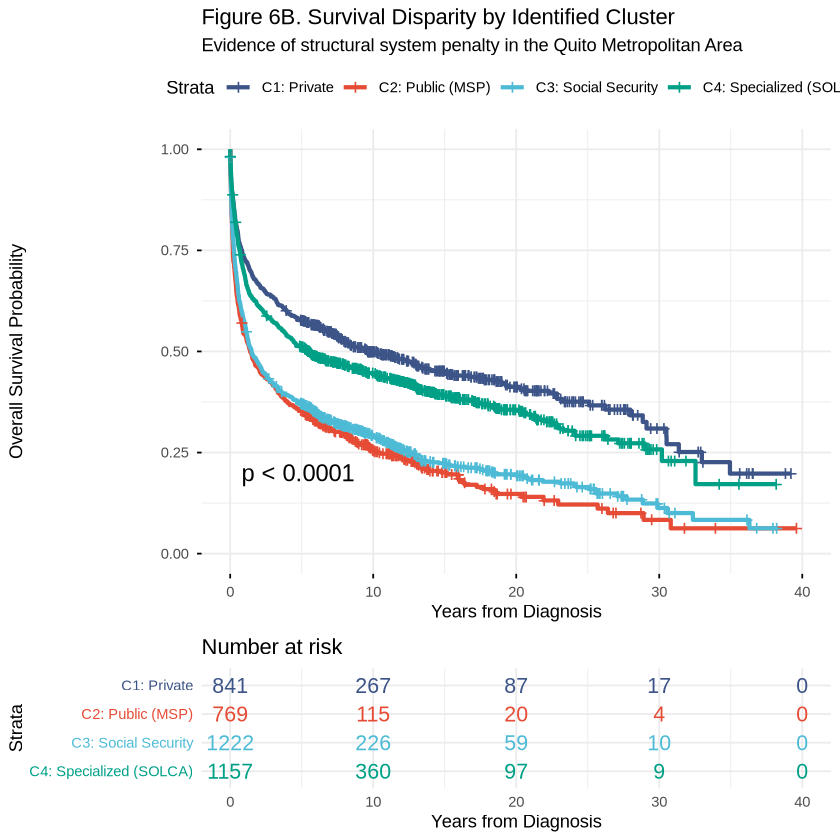

In [16]:
# 16. Create the survival plot
# Ensuring the survival data and vital status are perfectly matched to the clusters
df_km_final <- df_clean_en %>%
  mutate(
    # Mapping the vital status back to English/Numeric format
    Status = as.numeric(as.character(Status)),
    Survival_Time = Years_with_Cancer
  )

# FIT THE SURVIVAL MODEL
km_fit <- survfit(Surv(Survival_Time, Status) ~ Cluster, data = df_km_final)
# GENERATE THE MANUSCRIPT-READY KM PLOT
final_km_plot <- ggsurvplot(
  km_fit,
  data = df_km_final,
  linewidth = 1.2,           # Modern replacement for 'size'
  palette = c("#3C5488FF", "#E64B35FF", "#4DBBD5FF", "#00A087FF"),
  pval = TRUE,               # Log-rank test result
  conf.int = FALSE,          # Kept off for visual clarity
  risk.table = TRUE,         # Crucial for Q1 journals
  risk.table.col = "strata",
  legend.labs = c("C1: Private", "C2: Public (MSP)", 
                  "C3: Social Security", "C4: Specialized (SOLCA)"),
  xlab = "Years from Diagnosis",
  ylab = "Overall Survival Probability",
  title = "Figure 6B. Survival Disparity by Identified Cluster",
  subtitle = "Evidence of structural system penalty in the Quito Metropolitan Area",
  ggtheme = theme_minimal()
)

# Render the plot
print(final_km_plot)

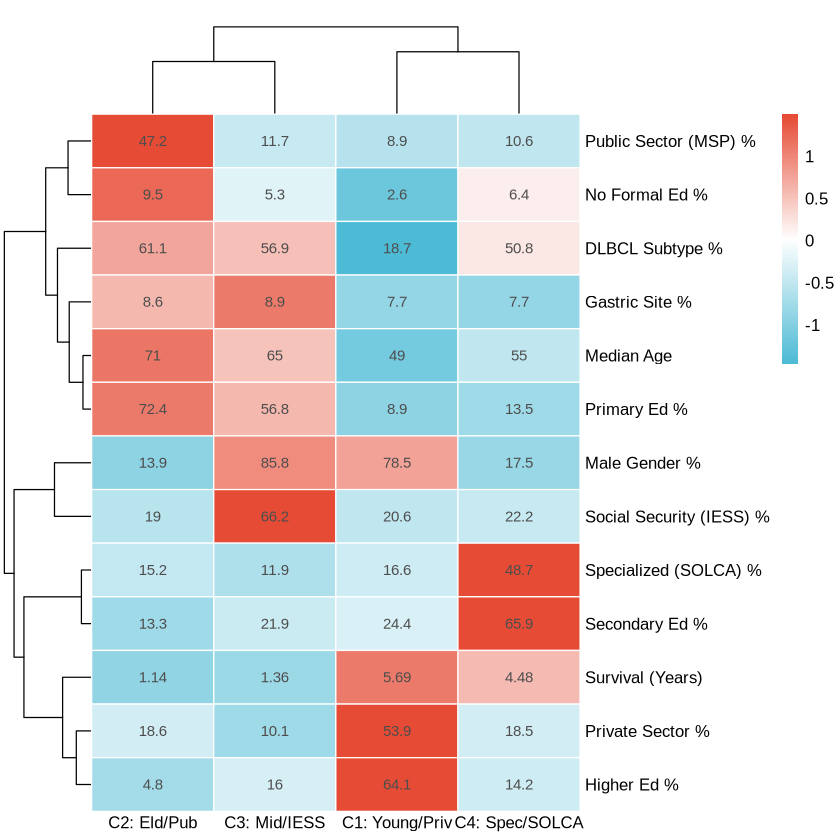

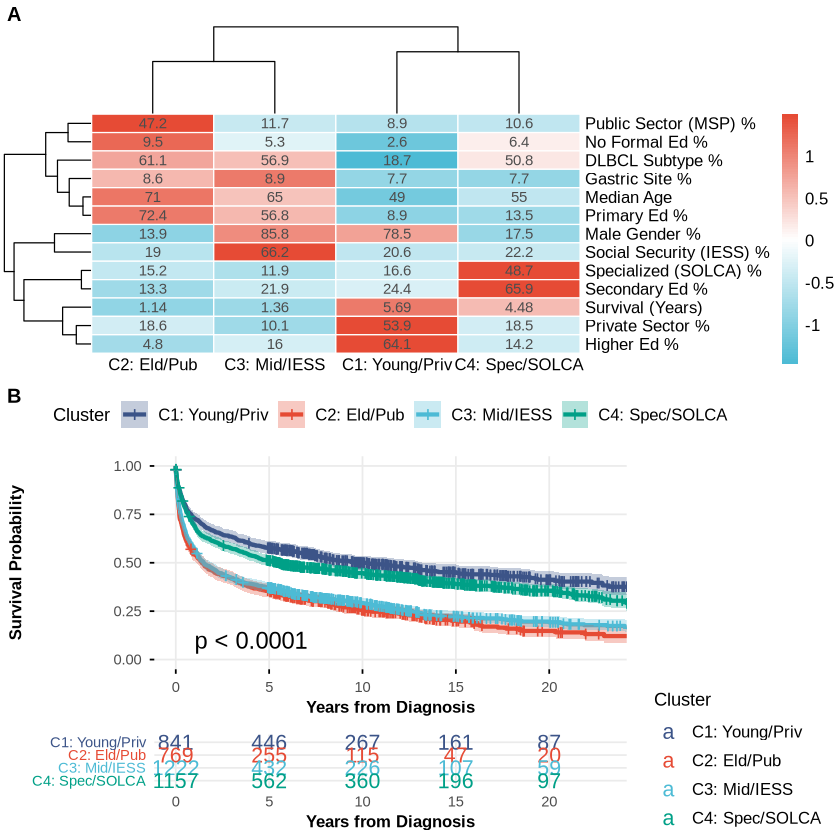

In [37]:
# 17. Create figure with two panels for the manuscript.
# --- PANEL A: REFINED HEATMAP (Same Scaling as Table 2) ---
# Ensure your 'heatmap_scaled' and 'heatmap_labels' include the new variables (Male%, Secondary Ed%)
hmap_plot_clean <- pheatmap(heatmap_scaled, 
                            display_numbers = heatmap_labels,
                            number_format = "%.1f",
                            # Using a lighter blue from your KM palette for contrast
                            color = colorRampPalette(c("#4DBBD5FF", "white", "#E64B35FF"))(100), 
                            border_color = "white",
                            angle_col = 0,
                             fontsize = 10,             # Base font size for axes/labels
                            fontsize_number = 9,      # Cell numbers (slightly smaller to fit)
                            main = "") 

hmap_grob <- hmap_plot_clean$gtable

# --- PANEL B: SURVIVAL ANALYSIS (With Standardized Styling) ---
km_fit <- survfit(Surv(Survival_Time, Status) ~ Cluster, data = df_km_final)

km_res <- ggsurvplot(
  km_fit,
  data = df_km_final,
  linewidth = 1.2,
  palette = c("#3C5488FF", "#E64B35FF", "#4DBBD5FF", "#00A087FF"),
  xlim = c(0, 23),
  break.x.by = 5,
  pval = "p < 0.0001",      # Static p-value for cleaner look
  pval.coord = c(1, 0.1),   # Positioned away from curves
  risk.table = TRUE,
  risk.table.y.text = TRUE, # Save space on A4
  risk.table.col = "strata",
  legend.title = "Cluster",
  legend.labs = c("C1: Young/Priv", "C2: Eld/Pub", "C3: Mid/IESS", "C4: Spec/SOLCA"), 
  xlab = "Years from Diagnosis",
  ylab = "Survival Probability",
  conf.int = TRUE,          # Added: Standard requirement for Lancet family
  ggtheme = theme_minimal() + 
            theme(panel.grid.minor = element_blank(),
                  axis.title = element_text(size = 10, face = "bold"),
                  legend.text = element_text(size = 10))
)

# Extract and clean components
km_plot_gg <- km_res$plot + theme(plot.title = element_blank())
km_table_gg <- km_res$table + theme(plot.title = element_blank(), 
                                    axis.title.y = element_blank())

# --- ASSEMBLY (A4 PORTRAIT COMPOSITE) ---

# Sub-panel for KM Curve and Risk Table
# Adjusted heights: Curve gets more room than the numbers
panel_b <- plot_grid(km_plot_gg, km_table_gg, ncol = 1, rel_heights = c(3, 1), align = "v")

# Main composite: Vertical stack
final_composite <- plot_grid(
  hmap_grob, 
  panel_b, 
  labels = c("A", "B"), 
  label_size = 16,
  ncol = 1, 
  rel_heights = c(1, 1.2) # Heatmap is slightly shorter to leave room for the KM details
)

# --- FINAL EXPORT ---
# Using standard A4 dimensions with safe margins
ggsave("images/Figure_Composite.png", 
       plot = final_composite, 
       width = 8.27, height = 11.69, units = "in", dpi = 600, 
       bg = "white")

# --- REVISED LABELING ---
final_composite <- plot_grid(
  hmap_grob, 
  panel_b, 
  labels = c("A", "B"), 
  label_size = 12,           # Changed from 16 to 12 for journal standard
  label_fontface = "bold",   # Standard practice to make labels bold
  label_x = 0,               # Ensures labels are tucked into the top-left corner
  label_y = 1,
  ncol = 1, 
  rel_heights = c(1, 1.2) 
)
# --- FINAL EXPORT: Optimized for A4 Full Page with Legend ---
ggsave("images/Figure6_Composite_Final.pdf", 
       plot = final_composite, 
       device = "pdf",
       width = 180,              # Double-column width
       height = 225,             # Optimized height to leave room for the legend
       units = "mm", 
       useDingbats = FALSE, 
       bg = "white")
final_composite

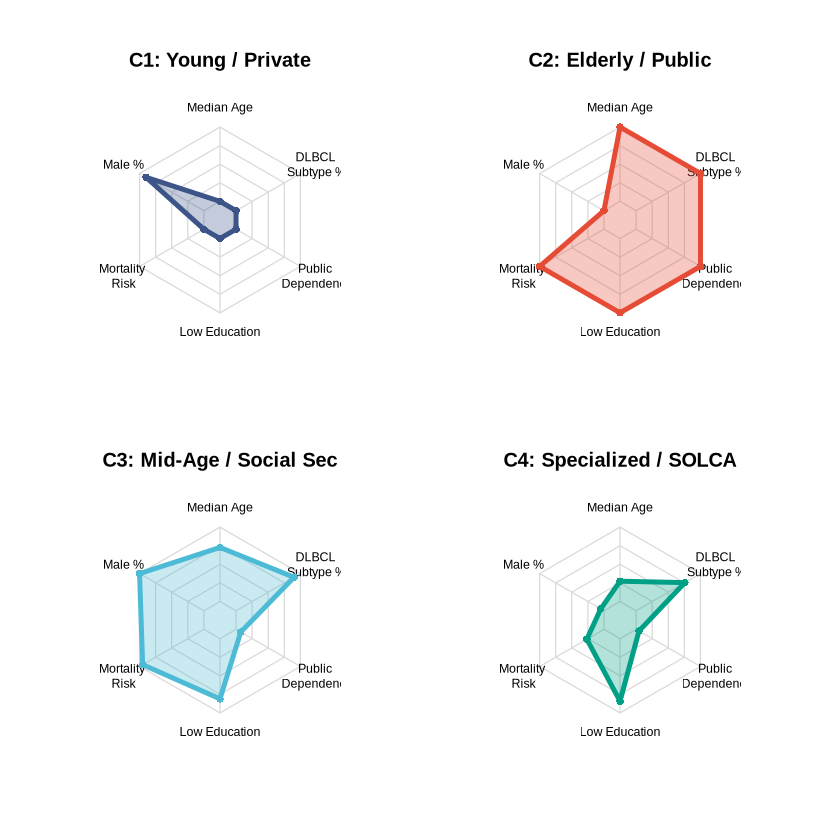

In [18]:
# 18. Create supplementary figure radar chart.
# Prepare Data with "Outward-Risk" Logic
radar_data <- full_scope_table %>%
  mutate(
    # Full descriptive names
    Phenotype = case_when(
      Cluster == 1 ~ "C1: Young / Private",
      Cluster == 2 ~ "C2: Elderly / Public",
      Cluster == 3 ~ "C3: Mid-Age / Social Sec",
      Cluster == 4 ~ "C4: Specialized / SOLCA"
    ),
    # Risk-oriented transformations
    Mortality_Risk = (max(Median_Survival_Yrs) - Median_Survival_Yrs),
    Education_Gap = (100 - Pct_Higher_Edu)
  ) %>%
  select(Phenotype, 
         `Median Age` = Median_Age, 
         `Male %` = Pct_Male,
         `Mortality \nRisk` = Mortality_Risk, 
         `Low Education` = Education_Gap, 
         `Public \nDependency` = Pct_Public_MSP, 
         `DLBCL \nSubtype %` = Pct_DLBCL_Subtype) %>%
  mutate(across(-Phenotype, ~ (. - min(.)) / (max(.) - min(.)))) %>%
  column_to_rownames("Phenotype")

# Setup max/min (fmsb requirements)
radar_final <- rbind(rep(1, 6), rep(0, 6), radar_data)

# Final A4 Layout with Margin Fixes
# Increase 'mar' (margins) to prevent label clipping
par(mfrow = c(2, 2), mar = c(4, 4, 4, 4), oma = c(1, 1, 1, 1))

colors_border <- c("#3C5488FF", "#E64B35FF", "#4DBBD5FF", "#00A087FF")
colors_in <- c(alpha("#3C5488FF", 0.3), alpha("#E64B35FF", 0.3), 
               alpha("#4DBBD5FF", 0.3), alpha("#00A087FF", 0.3))

for(i in 1:4){
  radarchart(radar_final[c(1, 2, i+2), ], 
             axistype = 0, 
             pcol = colors_border[i], 
             pfcol = colors_in[i], 
             plwd = 4, 
             cglcol = "grey85", 
             cglty = 1, 
             vlcex = 0.75, # Slightly smaller font to prevent clipping
             title = rownames(radar_final)[i+2])
}